# Unsupervised Clustering Methods for Meteorological European Configurations/ Patterns



<span style="color: yellow;">- In 2.2 vedere se standard scaler va bene o se è emglio usare robust scaler, per ora dovrebbe andare bene</span>  
<span style="color: yellow;">- eventualmente nella standardizzazione posso demarcare la cella sopra che ha le funzioni per il calcolo della memoria (no)</span> 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 1 Caricamento Dati e Analisi Iniziale

In [2]:
try:
    ds = xr.open_dataset('era5_2000_2004.grib', engine= 'cfgrib') # XArray DataSet
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully.


In [3]:
print("Overview of the dataset:")
print(f"   • Variables: {list(ds.data_vars.keys())}")
print(f"   • Coordinates: {list(ds.coords.keys())}")

Overview of the dataset:
   • Variables: ['z', 't', 'u', 'v']
   • Coordinates: ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', 'valid_time']


In [4]:
# Dimenision details
print("Dimension details:")
if 'latitude' in ds.dims:
    print(f"   • Latitude: {ds.dims['latitude']} points ({ds.latitude.min().values:.1f}° - {ds.latitude.max().values:.1f}°)")
if 'longitude' in ds.dims:
    print(f"   • Longitude: {ds.dims['longitude']} points ({ds.longitude.min().values:.1f}° - {ds.longitude.max().values:.1f}°)")
if 'time' in ds.dims:
    print(f"   • Time: {ds.dims['time']} steps ({pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d')} - {pd.to_datetime(ds.time.values[-1]).strftime('%Y-%m-%d')})")
if 'isobaricInhPa' in ds.dims:
    print(f"   • Pressure levels: {ds.dims['isobaricInhPa']} levels ({list(ds.isobaricInhPa.values)} hPa)")

#Variables 
print("Variables in the dataset:")
for var in ds.data_vars:
    var_data = ds[var]
    print(f"   • {var}: {var_data.dims} - {var_data.attrs.get('long_name', 'N/A')}")
    print(f"     └─ Units: {var_data.attrs.get('units', 'N/A')}")


Dimension details:
   • Latitude: 201 points (20.0° - 70.0°)
   • Longitude: 321 points (-40.0° - 40.0°)
   • Time: 1827 steps (2000-01-01 - 2004-12-31)
   • Pressure levels: 3 levels ([np.float64(850.0), np.float64(500.0), np.float64(250.0)] hPa)
Variables in the dataset:
   • z: ('time', 'isobaricInhPa', 'latitude', 'longitude') - Geopotential
     └─ Units: m**2 s**-2
   • t: ('time', 'isobaricInhPa', 'latitude', 'longitude') - Temperature
     └─ Units: K
   • u: ('time', 'isobaricInhPa', 'latitude', 'longitude') - U component of wind
     └─ Units: m s**-1
   • v: ('time', 'isobaricInhPa', 'latitude', 'longitude') - V component of wind
     └─ Units: m s**-1


In [5]:
# Total dimensionality
total_spatial_points = 1
for dim in ['latitude', 'longitude']:
    if dim in ds.dims:
        total_spatial_points *= ds.dims[dim]

total_features = len(ds.data_vars) * ds.dims.get('isobaricInhPa', 1) * total_spatial_points
print("DIMENSIONALITY:")
print(f"   • Spatial points: {total_spatial_points}")
print(f"   • Total features per timestep: {total_features:,}")
print(f"   • Temporal samples: {ds.dims.get('time', 1)}")

DIMENSIONALITY:
   • Spatial points: 64521
   • Total features per timestep: 774,252
   • Temporal samples: 1827


Spatial points: punti griglia nello spazio. 
La regione osservata è suddivisa in una griglia regolare (0.25° x 0.25°), per ogni punto nella grigli avengono misurate le variabili

Total features per timestep: numero di variabili (features) in totale in ogni istante di tempo

Temporal samples: punti temporali nel dataset (365 giorni per 5 anni)

### 1.1 Check quality in data

In [6]:
# Missing values check: already verified to be 0
print("MISSING VALUES: No missing values (previously verified)")

MISSING VALUES: No missing values (previously verified)


There are no missing values in the dataset

## 2 Preprocessing and Feature Selection

### 2.1 Preparing Data Matrix

#### Struttura inziale dei dati

**Scatola** = Dataset   
dentro la scatola di sono dei blocchi di fogli

**Un blocco di fogli** = un signolo giorno ( da 1 gennaio 2000 a 21 dic 2004)  -> <span style="color: red;">1827 giorni</span>  
il blocco di fogli è formato da 4 fogli uno per ogni variabile

**Un foglio contiene i valori di una variabile** =  variabili: u, v, z, t -> <span style="color: red;">4 variabili</span>  

Ogni foglio contiene i valori di quella variabile presi in ogni singolo punto dello 'spazio' definito dalla longitudine e dalla laitudine. Quindi in ogni foglio c'è il valore di quella variabile in ognuno dei 201(lat) × 321(lon). Una specie di tabella.  -> <span style="color: red;">64521 punti spaziali</span>

**Solo che questa tabella di valori è presa per ognuno dei 3 livelli di pressione** = 850 hPa, 500 hPa, 250 hPa -> <span style="color: red;">3 lv di pressione</span>

**TOT= 774252 valori per blocco**   x 1827 giorni

Per ogni variabile:  
__per ogni livello di pressione:  
____per ogni lat:  
______per ogni lon:  
________prendi il valore  

Se penso al foglio come una tabella con 774252 colonne, e solo 1 riga, che rappresenta tutte le misure spaziali per quel giorno, posso mettere insieme tutti i 1827 fogli, e ottenere una matrice finale di forma (1827, 774252). Ogni riga è un giorno. Ogni colonna è una variabile a una certa posizione e pressione.


#### Struttura finale dei dati

L’obiettivo è trasformare tutto in una tabella 2D:

           feature_1  feature_2  ...  feature_774252  
time_1 →      ...        ...             ...  
time_2 →      ...        ...             ...  
  ⋮                             
time_1827 →   ...        ...             ...  

Righe: 1827 (una per ogni timestep)  
Colonne: 774,252 (una per ogni combinazione di punto spaziale × variabile)  

Organizzazione delle Colonne:  
[z_850_lat0_lon0, z_850_lat0_lon1, ..., z_500_lat0_lon0, ..., z_250_lat0_lon0, ...,  
 t_850_lat0_lon0, t_850_lat0_lon1, ..., t_500_lat0_lon0, ..., t_250_lat0_lon0, ...,  
 u_850_lat0_lon0, u_850_lat0_lon1, ..., u_500_lat0_lon0, ..., u_250_lat0_lon0, ...,  
 v_850_lat0_lon0, v_850_lat0_lon1, ..., v_500_lat0_lon0, ..., v_250_lat0_lon0, ...]  

In [7]:
# Convert dataset to 2D array 
def prepare_data_matrix(dataset):
    """Converts xarray dataset to 2D matrix"""
    data_matrices = {}
    
    for var in dataset.data_vars:
        print(f"   • Processing {var}...")
        var_data = dataset[var]
        
        # Reorganize dimensions: (time, features)
        if 'time' in var_data.dims:
            # Stack all non-temporal dimensions
            spatial_dims = [dim for dim in var_data.dims if dim != 'time']
            if spatial_dims:
                stacked = var_data.stack(features=spatial_dims)      # From: var[time=1827, pressure=3, lat=201, lon=321]
                matrix = stacked.values  # shape: (time, features)   # To:  var[time=1827, features=193563]  (3×201×321=193563)
            else:
                matrix = var_data.values.reshape(-1, 1)  # For variables without spatial dimensions
        else:
            matrix = var_data.values.flatten().reshape(1, -1)
        
        data_matrices[var] = matrix
    
    # Concatenate all variables
    all_matrices = list(data_matrices.values())
    combined_matrix = np.concatenate(all_matrices, axis=1)
    
    return combined_matrix, data_matrices


In [8]:
print("PREPARING DATA MATRIX")
X, data_matrices = prepare_data_matrix(ds)
print(f"Data Matrix: {X.shape} (samples, features)")

PREPARING DATA MATRIX
   • Processing z...
   • Processing t...
   • Processing u...
   • Processing v...
Data Matrix: (1827, 774252) (samples, features)


Prima (per la variabile z):  
z[time=0, pressure=850, lat=37.5, lon=12.0] = 1234.5  
z[time=0, pressure=500, lat=37.5, lon=12.0] = 5678.9  
z[time=0, pressure=250, lat=37.5, lon=12.0] = 9876.1  
...  

Dopo lo stack:  
z[time=0, feature_0] = 1234.5  # (850hPa, lat37.5, lon12.0)  
z[time=0, feature_1] = 5678.9  # (500hPa, lat37.5, lon12.0)    
z[time=0, feature_2] = 9876.1  # (250hPa, lat37.5, lon12.0)  
...  

Concatenazione finale:

X[time=0] = [z_features (tti i valori di z)... | t_features... | u_features... | v_features...]


### 2.2 Standardization

The next step is to standardize the data for each feature to achieve zero mean and unit variance (standard deviation = 1).Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data   
We use Scikit-learn's StandardScaler, which computes the mean and standard deviation across all samples. However, due to the massive dimensionality of our dataset (1827 × 774,252), loading all data into memory simultaneously would cause RAM saturation. To solve thi memory constraint we employ the _.partial_fit()_ method, which enables incremental standardization by processing the data in a streaming fashion - one sample at a time. This approach allows us to handle large datasets that exceed available memory while maintaining the same statistical properties as batch processing.

Media e varianza si possono calcolare incrementalmente invece che su tutti i dati in blocco.
Equivalente matematico:  
Invece di: mean = sum(all_data) / n  
Posso usare: mean_new = (mean_old * (n-1) + x_new) / n  

Per ora uso StandardScaler poichè i valori sono ben distribuiti. Ma nel caso la PCA o il Kmeans venissero strani posso provare ad utilizzare RobustScaler che è più robusto agli outliers.
  

Se ho problemi di RAM, posso:

    Ridurre le feature prima della standardizzazione (es. PCA incrementale).

In [9]:
print("STANDARDIZATION - Memory-Safe")

# Check if data is already standardized to avoid double-processing
#print("   • Checking if data is already standardized...")
sample_check = X[:3, :10].mean(axis=0)
#if np.allclose(sample_check, 0, atol=0.1):
#    print("  Data appears already standardized - SKIPPING!")
#    print(f"   • Dataset shape: {X.shape}")
#    print("   • If you want to re-standardize, restart kernel and reload data")
#else:
#    print("  Data in original scale - proceeding with standardization")

batch_size = 1
print(f"   • Batch size: {batch_size} ")

scaler = StandardScaler()

# Only proceed if data is not already standardized
if not np.allclose(sample_check, 0, atol=0.1):
    # Step 1: Calculate statistics one sample at a time
    print("   • Phase 1: Calculate statistics (1 sample at a time)...")
    for i in range(0, X.shape[0], batch_size):
        scaler.partial_fit(X[i:i+1])   # Online computation of mean and std on X for later scaling

        # Log every 500 samples to reduce overhead
        if i % 500 == 0:
            progress = (i / X.shape[0]) * 100
            gc.collect()

    print("   • partial_fit completed")

    # Step 2: Direct in-place transformation 
    print("   • Phase 2: In-place transformation...")
    for i in range(0, X.shape[0]):
        # Direct transformation on single row 
        X[i:i+1] = scaler.transform(X[i:i+1])   # Perform standardization by centering and scaling

        # Log every 500 samples to reduce overhead
        if i % 500 == 0:
            progress = (i / X.shape[0]) * 100

            # Garbage collection every 1000 samples
            if i % 1000 == 0:
                gc.collect()

    print(f"   • Standardization completed!")

print(f"   • Dataset shape: {X.shape}")

print("   • Standardization verification (per feature):")

# Check mean and std for first 3 features
mean_per_feature = X[:, :3].mean(axis=0)
std_per_feature = X[:, :3].std(axis=0)

print(f"   • Mean (per feature, first 3 feature): {mean_per_feature}")
print(f"   • Std  (per feature, first 3 feature): {std_per_feature}")

# Check mean and std for first 10 features
print("   • Mean (per feature, first 10 feature):", X[:, :10].mean(axis=0))
print("   • Std  (per feature, first 10 feature):", X[:, :10].std(axis=0))

STANDARDIZATION - Memory-Safe
   • Batch size: 1 
   • Phase 1: Calculate statistics (1 sample at a time)...
   • partial_fit completed
   • Phase 2: In-place transformation...
   • Standardization completed!
   • Dataset shape: (1827, 774252)
   • Standardization verification (per feature):
   • Mean (per feature, first 3 feature): [-2.9361894e-08  2.4402997e-08 -5.4808869e-09]
   • Std  (per feature, first 3 feature): [0.9999999  1.0000001  0.99999994]
   • Mean (per feature, first 10 feature): [-2.9361894e-08  2.4402997e-08 -5.4808869e-09 -2.0227082e-08
  6.0942241e-08  1.1744757e-09 -1.3049731e-08  2.7404434e-08
  2.1010067e-08 -3.6147753e-08]
   • Std  (per feature, first 10 feature): [0.9999999  1.0000001  0.99999994 1.0000004  0.99999994 0.9999995
 1.0000007  1.0000004  0.99999964 1.0000002 ]


PRIMA della standardizzazione:  
Colonna 0 (z_850_lat0_lon0): Valori di geopotenziale a 850hPa nel punto (lat0,lon0) per TUTTI i 1827 giorni  
Esempio: [10815, 10820, 10805, 10830, ...] → 1827 valori diversi  

DOPO la standardizzazione:  
Colonna 0: Calcolo mean e std di quei 1827 valori  
Esempio: mean=10818, std=15  
Ogni valore diventa: (valore_originale - 10818) / 15  
Risultato: [-0.2, 0.13, -0.87, 0.8, ...] → media=0, std=1  

Cosa Significa:
La standardizzazione normalizza ogni punto geografico-variabile rispetto alla sua variabilità temporale.

Ad esempio:   
Prima: Geopotenziale a Milano a 850hPa varia da 1480 a 1520 metri nei 5 anni  
Dopo: Questi valori diventano da -2.1 a +1.8 (media=0, std=1)  
Interpretazione: Ora puoi confrontare la "anomalia" di Milano con quella di Roma, anche se hanno scale diverse!  

Now, an esample of standardization for 3 points is shown.

![Esempio Standardizzazione](./standardization_example.png)

### 2.3 PCA

Step 1: PCA Incrementale  
L'obiettivo è di riuscire a descrivere un dato sistema in modo chiaro e sufficientemente accurato
usando un numero ridotto di variabili, mantenendo il più possibile l’informazione (varianza) contenuta nei dati originali.  

IncrementalPCA elabora i dati un batch alla volta (100 righe) e aggiorna i componenti principali progressivamente.

<span style="color: orange;">Non adatta se:  
le variabili originali hanno un significato interpretativo importante (perché le componenti PCA sono combinazioni lineari difficili da interpretare)</span>



**Varianza = quanto i dati si "spargono" attorno alla media**
- La PCA cerca le **direzioni di MASSIMA varianza**   
- Trova i pattern meteorologici che cambiano di più nel tempo  
- Cattura le configurazioni atmosferiche principali (NAO, anticicloni, ecc.)  

**Cosa significa "90% di varianza spiegata"?**

Ognuna delle 774252 variabili ha la sua varianza:
- Geopotenziale a Milano: varia tanto → ALTA varianza
- Temperatura nel Sahara: varia poco → BASSA varianza

1. **Trova la Prima Componente**: la direzione che spiega PIÙ varianza possibile
   - Es: "Anticiclone vs. Ciclone" → spiega il 35% della varianza totale

2. **Trova la Seconda Componente**: la direzione che spiega la SECONDA più alta varianza
   - Es: "Estate vs. Inverno" → spiega il 20% della varianza

3. **Continua così...** fino ad avere tutte le componenti


<span style="color: orange;"> La PCA non assegna etichette o categorie: ogni campione rimane un punto nello spazio, solo rappresentato in modo più efficiente. Le componenti non sono cluster, ma assi cartesiani scelti in modo che la varianza sia massima lungo il primo asse, poi il secondo ecc. Quindi la PCA non è un clustering, anche se può rivelare struttura nei dati.

In [ ]:
print("INCREMENTAL PCA ANALYSIS")

# Memory-efficient PCA with incremental processing
# Start with analysis of many components to understand variance distribution
n_components = 60   # Reduced to 50 components for safety with batch processing
batch_size = 100    # Increased batch size to accommodate more components

print(f"   • Target components: {n_components}")
print(f"   • Batch size: {batch_size}")
print(f"   • Data shape: {X.shape}")

# Ensure batch_size doesn't exceed total samples
if batch_size > X.shape[0]:
    batch_size = X.shape[0]
    print(f"   • Adjusted batch size to total samples: {batch_size}")

# Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

print("   • Phase 1: Fitting incremental PCA...")
# Fit the PCA incrementally
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    ipca.partial_fit(batch)
    
    # Progress tracking
    if i % (batch_size * 10) == 0:  # Every 10 batches
        progress = min(100, (i + batch_size) / X.shape[0] * 100)
        print(f"      └─ Progress: {progress:.1f}%")
        gc.collect()

print("   • Phase 2: Transforming data...")
# Transform data in batches to avoid memory issues
X_pca = np.zeros((X.shape[0], n_components))

for i in range(0, X.shape[0], batch_size):
    end_idx = min(i + batch_size, X.shape[0])
    batch = X[i:end_idx]
    X_pca[i:end_idx] = ipca.transform(batch)
    
    # Progress tracking
    if i % (batch_size * 10) == 0:  # Every 10 batches
        progress = min(100, (i + batch_size) / X.shape[0] * 100)
        print(f"      └─ Progress: {progress:.1f}%")
        gc.collect()

print(f"   • PCA transformation completed!")
print(f"   • Original shape: {X.shape}")
print(f"   • PCA shape: {X_pca.shape}")

# Analyze explained variance
explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\n   • VARIANCE ANALYSIS:")
print(f"   • Total explained variance ({n_components} components): {cumulative_variance[-1]:.3f}")

# Find components needed for different variance thresholds
thresholds = [0.80, 0.85, 0.90, 0.95]
for threshold in thresholds:
    n_comp_needed = np.argmax(cumulative_variance >= threshold) + 1
    if cumulative_variance[-1] >= threshold:
        print(f"   • {threshold*100}% variance: {n_comp_needed} components")
    else:
        print(f"   • {threshold*100}% variance: >{n_components} components needed")

# Show variance distribution for first components
print(f"\n   • First 10 components variance: {explained_variance_ratio[:10]}")
print(f"   • First 50 components cumulative: {cumulative_variance[49]:.3f}")

INCREMENTAL PCA ANALYSIS
   • Target components: 60
   • Batch size: 100
   • Data shape: (1827, 774252)
   • Phase 1: Fitting incremental PCA...
      └─ Progress: 5.5%
      └─ Progress: 60.2%
   • Phase 2: Transforming data...
      └─ Progress: 5.5%
      └─ Progress: 60.2%
   • PCA transformation completed!
   • Original shape: (1827, 774252)
   • PCA shape: (1827, 60)

   • VARIANCE ANALYSIS:
   • Total explained variance (60 components): 0.850
   • 80.0% variance: 35 components
   • 85.0% variance: >60 components needed
   • 90.0% variance: >60 components needed
   • 95.0% variance: >60 components needed

   • First 10 components variance: [0.26235129 0.07127485 0.06121076 0.05527094 0.04657589 0.0373427
 0.02761811 0.02242706 0.02087703 0.01766382]
   • First 20 components cumulative: 0.732


La PCA con 50 componenti spiega l’83.3% della varianza totale, sufficiente per molti scopi pratici, ma non per superare soglie più alte (es. 90% o 95%), che richiederebbero ancora più componenti.

Il grafico mostra chiaramente un forte “elbow” nei primi componenti: la prima componente da sola spiega il 26.2% (!), la seconda il 7.1%, e poi via via la varianza scende rapidamente → significa che gran parte dell’informazione è concentrata nei primi component

    Analisi della varianza

    calcola la percentuale di varianza spiegata da ciascun componente  
    calcola la cumulata (cioè quanto “copre” l’informazione aggiungendo via via più componenti)  
    stampa quante componenti servono per spiegare almeno l’80%, 90%, 95% della varianza



- la prima componente da sola spiega il 26% della varianza → fortemente dominante
- le prime 10 componenti arrivano circa al 60% cumulato
- per arrivare all’80% servono 36 componenti
- con 50 componenti si arriva all’83% → buono ma non eccellente se vogliamo 90% <span style="color: lightblue;">per arrivare al 90% ci vorrebbero più di 50 componenti, quindi servirebbe ripetere con n_components più alto se l’obiettivo è qualità massima</span>

VARIANCE VISUALIZATION


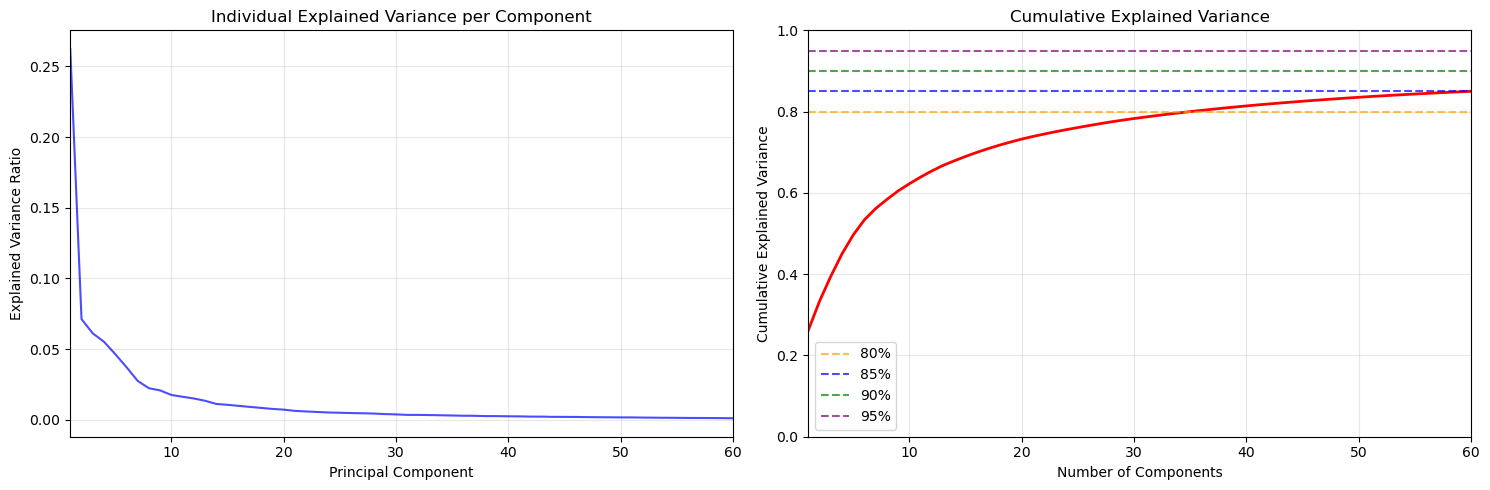

In [14]:
# Visualization of explained variance
print("VARIANCE VISUALIZATION")

# Create plots for variance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Individual explained variance ratio
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'b-', alpha=0.7)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Individual Explained Variance per Component')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 60)  # Focus on first 60 components

# Plot 2: Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', linewidth=2)
ax2.axhline(y=0.80, color='orange', linestyle='--', alpha=0.7, label='80%')
ax2.axhline(y=0.85, color='blue', linestyle='--', alpha=0.7, label='85%')
ax2.axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90%')
ax2.axhline(y=0.95, color='purple', linestyle='--', alpha=0.7, label='95%')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, n_components)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()


Grafico a sinistra: varianza spiegata individualmente da ciascuna componente (curve blu decrescente).

Grafico a destra: varianza cumulativa spiegata dalle componenti, con linee orizzontali alle soglie 80%, 90%, 95% per capire visivamente quanti componenti servono.

    grafico a sinistra: varianza spiegata per singola componente
    (di solito decresce velocemente, “elbow” shape)  
    mostra la varianza spiegata da ciascun componente  
    conferma che la prima componente è molto informativa  
    curva a gomito → tipico nei dati ridondanti

    grafico a destra: varianza spiegata cumulata
    (sale a gradini, fino a saturare verso 1)  
    mostra la varianza cumulata
    le linee orizzontali (80%, 90%, 95%) ti fanno capire quanto margine hai  
    la curva rossa sale rapidamente ma si stabilizza, quindi i componenti successivi hanno impatto minore

<span style="color: orange;">la PCA permette di proiettare i dati in un nuovo spazio ridotto che mantiene la maggior parte dell’informazione
Inoltre, facilita interpretazioni fisiche (ad esempio i primi componenti possono corrispondere a pattern meteorologici dominanti) e riduce il rumore e la ridondanza tra variabili</span>

<span style="color: red;">Se faccio un grafico dei primi 2 componenti e noto due nuvole distinte di punti, quello suggerisce che c'è una struttura a cluster.</span>

### **ORA PREPARARE IL DATASET RIDOTTO CON IL NUMERO DESIDERATO DI PRICNIPAL COMPONENTS**

Step 2: Analisi Varianza  (Plot varianza spiegata)
Vedere quante componenti servono per 90% varianza  
Plot: varianza cumulativa vs numero componenti  
Devo scegliere le dim finali (probabilmente 20-80 componenti)  

3. Correlazione tra VARIABILI (non tutte le features)  
Cerco correlazioni tra le 4 variabili meteorologiche aggregate  
Invece di 774k×774k → 4×4 matrice gestibile  
Correlazioni tra variabili meteorologiche (aggregate per livello)
